# A Deep Learning Program Run on Commercial Pelagic Vessels in the Pacific

**Packages Used**

In [1]:
import shutil 
import keras
from tensorflow.keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import *
from keras.preprocessing import image
import numpy as np
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping # early stopping
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
np.random.seed(34)

Here We load in our initial data set which is a CSV of image identification labels and labels of what is present aboard the vessel. I will look solely at the label category in this data frame, which has the categories ['HUMAN', 'NoF', 'YFT', 'ALB', 'OTH', 'BILL', 'DOL', 'BET', 'SKJ', 'LAG', 'SHARK', 'OIL', 'PLS', 'TUNA', 'WATER'],

In [2]:

df = pd.read_csv("../input/image-codes-data-set/fish.csv")
print(df.size)
df = df.drop_duplicates()
print(df.size)
print(df.head())

812926
317820
                                 img_id  label
0  94a69b66-23f0-11e9-a78e-2f2b7983ac0d  HUMAN
1  94a6a3a4-23f0-11e9-a78f-ebd9c88ef3e8  HUMAN
2  94a6a430-23f0-11e9-a790-2b5f72f1667a  HUMAN
3  94a6a48a-23f0-11e9-a791-fb958b6ab6b3  HUMAN
4  94a6a4da-23f0-11e9-a792-f320b734bd9b  HUMAN


There are over 86,000 unqiue images in this dataframe.

In [3]:
imgs = df.img_id.unique()
imgs.size

86029

# ** FROM HERE THIS IS HOW I TRANSFERRED MY LARGER CSV TO A SMALLER CSV WITH UNIQUE IMAGES **

In [4]:
df2= pd.DataFrame()
df2["img_id"] = imgs

In [5]:
class_names = list(df.label.unique())
print(class_names)

['HUMAN', 'NoF', 'YFT', 'ALB', 'OTH', 'BILL', 'DOL', 'BET', 'SKJ', 'LAG', 'SHARK', 'OIL', 'PLS', 'TUNA', 'WATER']


In [6]:
for i in class_names:
    df2[i]= ""

In [7]:
img_ids= df["img_id"]
img_ids[2]

'94a6a430-23f0-11e9-a790-2b5f72f1667a'

In [8]:
df2.head()

,img_id,HUMAN,NoF,YFT,ALB,OTH,BILL,DOL,BET,SKJ,LAG,SHARK,OIL,PLS,TUNA,WATER
0,94a69b66-23f0-11e9-a78e-2f2b7983ac0d,,,,,,,,,,,,,,,
1,94a6a3a4-23f0-11e9-a78f-ebd9c88ef3e8,,,,,,,,,,,,,,,
2,94a6a430-23f0-11e9-a790-2b5f72f1667a,,,,,,,,,,,,,,,
3,94a6a48a-23f0-11e9-a791-fb958b6ab6b3,,,,,,,,,,,,,,,
4,94a6a4da-23f0-11e9-a792-f320b734bd9b,,,,,,,,,,,,,,,


In [9]:
df3 = df.loc[df['img_id'] == 'dae032c2-db28-11ea-a22a-3bb828e9f7d1']
x= df3["label"]
x

406459      YFT
406460    HUMAN
Name: label, dtype: object

['HUMAN', 'NoF', 'YFT', 'ALB', 'OTH', 'BILL', 'DOL', 'BET', 'SKJ', 'LAG', 'SHARK', 'OIL', 'PLS', 'TUNA', 'WATER']

In [10]:
#df_subset= imgs.sample(n=10000, random_state = 1)
subset_imgs=np.random.choice(imgs, size= 10000)
subset_imgs.size


10000

In [11]:
df_sub= pd.DataFrame()
df_sub["img_id"] = subset_imgs
for i in class_names:
    df_sub[i]= ""
df_sub.head()

,img_id,HUMAN,NoF,YFT,ALB,OTH,BILL,DOL,BET,SKJ,LAG,SHARK,OIL,PLS,TUNA,WATER
0,dabf988c-db28-11ea-b646-f751770c2667,,,,,,,,,,,,,,,
1,da4cbfa6-db28-11ea-b466-bb5f9e1c58d1,,,,,,,,,,,,,,,
2,94d2518e-23f0-11e9-a8ae-97372c179db9,,,,,,,,,,,,,,,
3,da97f94e-db28-11ea-a4e2-6bc6f4fb7b0e,,,,,,,,,,,,,,,
4,dad1c426-db28-11ea-bb6b-3f63cdd14d9d,,,,,,,,,,,,,,,


In [12]:
label = df[df['img_id']=='94a6a584-23f0-11e9-a794-0fe64977c9b7']
print(label)
df_sub

                                 img_id  label
7  94a6a584-23f0-11e9-a794-0fe64977c9b7  HUMAN


,img_id,HUMAN,NoF,YFT,ALB,OTH,BILL,DOL,BET,SKJ,LAG,SHARK,OIL,PLS,TUNA,WATER
0,dabf988c-db28-11ea-b646-f751770c2667,,,,,,,,,,,,,,,
1,da4cbfa6-db28-11ea-b466-bb5f9e1c58d1,,,,,,,,,,,,,,,
2,94d2518e-23f0-11e9-a8ae-97372c179db9,,,,,,,,,,,,,,,
3,da97f94e-db28-11ea-a4e2-6bc6f4fb7b0e,,,,,,,,,,,,,,,
4,dad1c426-db28-11ea-bb6b-3f63cdd14d9d,,,,,,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,da4ff568-db28-11ea-bd6a-df8d86f2201b,,,,,,,,,,,,,,,
9996,da70e764-db28-11ea-a998-032d777e921b,,,,,,,,,,,,,,,
9997,94e1c5a6-23f0-11e9-ba0a-872605079058,,,,,,,,,,,,,,,
9998,da5157aa-db28-11ea-ba47-af1043ec9532,,,,,,,,,,,,,,,


In [13]:
#for j, row in df.iterrows():
 #   for i in df_sub["img_id"]:
  #      if i == row['img_id']:
   #         label = row['label']
    #        df_sub.loc[df_sub['img_id'] == i, [label]] = 1
            

# I have now created a smaller dataframe that represents a subset of images that have the labels as columns and a binary 1 or 0 depicting if the column label is present or not.

In [14]:
subsetted= pd.read_csv("../input/subsetted/file_name.csv")


In [15]:
 os.makedirs('image')


In [16]:
proper = subsetted.fillna(0)

proper = proper.drop(columns="Unnamed: 0")
proper.head()

,img_id,HUMAN,NoF,YFT,ALB,OTH,BILL,DOL,BET,SKJ,LAG,SHARK,OIL,PLS,TUNA,WATER
0,dabf988c-db28-11ea-b646-f751770c2667,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,da4cbfa6-db28-11ea-b466-bb5f9e1c58d1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,94d2518e-23f0-11e9-a8ae-97372c179db9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,da97f94e-db28-11ea-a4e2-6bc6f4fb7b0e,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,dad1c426-db28-11ea-bb6b-3f63cdd14d9d,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
list_ids= list(proper['img_id'])
list_ids[3]

'da97f94e-db28-11ea-a4e2-6bc6f4fb7b0e'

Moving the subset of images into a unique file

In [18]:
for i in tqdm(list_ids):
    c = i+'.jpg'
    get_image = '/kaggle/input/attempt-13/foid_images_v020/images/' + c
        #if os.path.exists(get_image):
            #print('i')
            #move_image = shutil.move(get_image,'/kaggle/working/image_/'+i)
    if not os.path.exists('/kaggle/input/attempt-13/foid_images_v020/images/'+c):
            print("FAILED")
            break
    #if os.path.exists('/kaggle/working/image/'+c):
           #print("CREATED")
           #break
    else:
        move_image = shutil.copy(get_image,'/kaggle/working/image/')

100%|██████████| 10000/10000 [01:03<00:00, 157.92it/s]


In [19]:
proper_sub= proper.head(1000)


# Here I have created the training numpy array for the , ram issues have me to downsize to 1000 images

In [20]:
proper_sub.head()

,img_id,HUMAN,NoF,YFT,ALB,OTH,BILL,DOL,BET,SKJ,LAG,SHARK,OIL,PLS,TUNA,WATER
0,dabf988c-db28-11ea-b646-f751770c2667,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,da4cbfa6-db28-11ea-b466-bb5f9e1c58d1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,94d2518e-23f0-11e9-a8ae-97372c179db9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,da97f94e-db28-11ea-a4e2-6bc6f4fb7b0e,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,dad1c426-db28-11ea-bb6b-3f63cdd14d9d,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
train_image = []
for i in tqdm(range(proper_sub.shape[0])):
    img = image.load_img('./image/'+proper['img_id'][i]+'.jpg',target_size=(400,400,3))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|██████████| 1000/1000 [00:15<00:00, 65.91it/s]


In [22]:
X.shape

(1000, 400, 400, 3)

 for j in class_names:
        if j in tags:
            df_sub.at[i, j] =1
        else:
            df_sub.at[i, j] =0

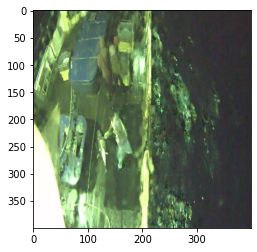

In [23]:
plt.imshow(X[2])

In [24]:
proper['HUMAN'][2]

1.0

# Creating the Y numpy array

In [25]:
proper_sub= proper.head(1000)

y = np.array(proper_sub.drop(['img_id'],axis=1))
y.shape

(1000, 15)

# Here I split the data into each of its part

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

# 

# Creating the Model and Summary

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(400,400,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(15, activation='sigmoid'))

In [27]:
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
#model2 = Sequential()
#model2.add()

base_model = MobileNetV2(input_shape = (400, 400, 3), include_top = False, weights = "imagenet")
x = base_model.output
x = GlobalAveragePooling2D()(x)
# ADD A DENSE LAYER WITH 1024 neurons
x = Dense(1024, activation='relu', kernel_initializer=HeNormal())(x)
# ADD AN OUTPUT LAYER FOR BINARY CLASSIFICATION
predictions = Dense(15, activation='sigmoid')(x)
model2 = Model(inputs=base_model.input, outputs=predictions)


2022-05-06 10:44:56.523008: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 10:44:56.637889: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 10:44:56.638743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 10:44:56.640290: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

9420800/9406464 [==============================] - 0s 0us/step


In [28]:
model2.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7f8a14717410>>

from keras.utils.vis_utils import plot_model
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Compiling and fitting the Model

In [29]:
#freezing layers attempt 1.0
#accuracy -> 0
#decision not to freeze layers

#for layer in model2.layers[:172]:
       #layer.trainable = False
#for layer in model2.layers[172:]:
       #layer.trainable = True

In [30]:
from tensorflow.keras.optimizers import SGD
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), metrics=['accuracy'], 
              loss='binary_crossentropy')
#restore if failure
#model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
es = EarlyStopping(patience=3, restore_best_weights=True, monitor='val_accuracy') # Early stopping

fitted_model_0 = model.fit(X_train, y_train, batch_size=64, 
                            epochs=20, validation_split=0.2, 
                            callbacks=[es])

In [32]:

fitted_model= model2.fit(X_train, y_train, batch_size=64, 
                            epochs=20, validation_split=0.2)


2022-05-06 10:45:09.137952: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1382400000 exceeds 10% of free system memory.
2022-05-06 10:45:10.612963: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1382400000 exceeds 10% of free system memory.
2022-05-06 10:45:11.624391: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-05-06 10:45:15.114959: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 122880000 exceeds 10% of free system memory.
2022-05-06 10:45:15.115669: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 122880000 exceeds 10% of free system memory.
2022-05-06 10:45:15.272708: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 122880000 exceeds 10% of free system memory.
2022-05-06 10:45:16.074122: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


12/12 [==============================] - 25s 1s/step - loss: 0.7352 - accuracy: 0.0028 - val_loss: 0.6639 - val_accuracy: 0.0111
Epoch 2/20
12/12 [==============================] - 12s 996ms/step - loss: 0.7016 - accuracy: 0.0042 - val_loss: 0.6320 - val_accuracy: 0.0111
Epoch 3/20
12/12 [==============================] - 12s 998ms/step - loss: 0.6595 - accuracy: 0.0042 - val_loss: 0.5988 - val_accuracy: 0.0222
Epoch 4/20
12/12 [==============================] - 12s 1000ms/step - loss: 0.6189 - accuracy: 0.0125 - val_loss: 0.5676 - val_accuracy: 0.0611
Epoch 5/20
12/12 [==============================] - 12s 1s/step - loss: 0.5821 - accuracy: 0.0472 - val_loss: 0.5393 - val_accuracy: 0.2278
Epoch 6/20
12/12 [==============================] - 12s 1s/step - loss: 0.5475 - accuracy: 0.1181 - val_loss: 0.5137 - val_accuracy: 0.3056
Epoch 7/20
12/12 [==============================] - 12s 987ms/step - loss: 0.5182 - accuracy: 0.2278 - val_loss: 0.4906 - val_accuracy: 0.4389
Epoch 8/20
12/12 [

from keras.callbacks import History, EarlyStopping


# Evaluating the Model


acc = fitted_model_0.history['accuracy']
val_acc = fitted_model_0.history['val_accuracy']
loss = fitted_model_0.history['loss']
val_loss = fitted_model_0.history['val_loss']
epochs_range = range(8)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

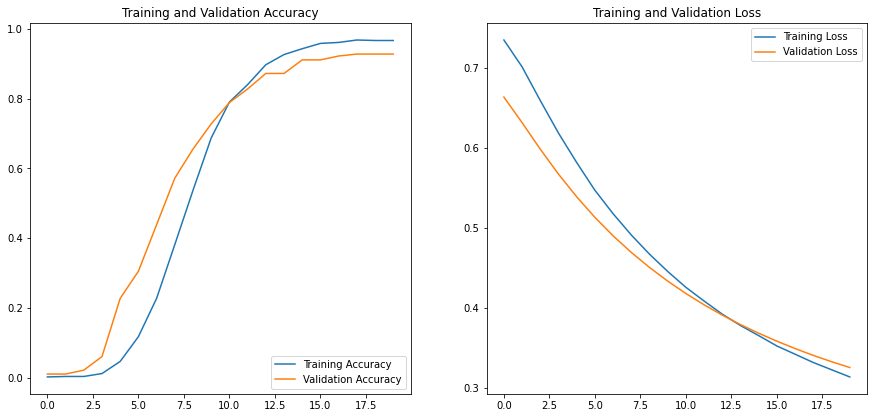

In [33]:
acc = fitted_model.history['accuracy']
val_acc = fitted_model.history['val_accuracy']
loss = fitted_model.history['loss']
val_loss = fitted_model.history['val_loss']
epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The model seems has accuracy of 95%, which is very impressive. 

In [34]:
from sklearn.metrics import classification_report,confusion_matrix

predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

classes_x

predictions = classes_x
predictions = predictions.reshape(1,-1)[0]


print(model.evaluate(X_test, y_test))



In [35]:
print(model2.evaluate(X_test, y_test))

4/4 [==============================] - 1s 100ms/step - loss: 0.3308 - accuracy: 0.9500
[0.3308255672454834, 0.949999988079071]


In [36]:
preds2 = model2.predict(X_test[:10])

preds = model.predict(X_test[:10])

# Model Diagnostics

In [37]:
np.round(preds2)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

In [38]:
y_test[:10]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

plt.imshow(X[2])
print(np.round(preds))
print(y_test[:10])

x= X[2]
plt.imshow(X[2])
x = np.expand_dims(x, 0)
print(x.shape)
x = preprocess_input(x)

preds_singular = model2.predict(x)
print('Predicted class:')
preds_singular.shape


In [39]:
from sklearn.metrics import multilabel_confusion_matrix
preds = model2.predict(X_test) 
y_pred = np.round(preds)
multilabel_confusion_matrix(y_test, y_pred)

array([[[  0,   5],
        [  0,  95]],

       [[ 95,   0],
        [  5,   0]],

       [[ 56,  23],
        [ 14,   7]],

       [[ 62,   9],
        [ 26,   3]],

       [[ 94,   0],
        [  6,   0]],

       [[ 90,   2],
        [  7,   1]],

       [[ 95,   0],
        [  5,   0]],

       [[ 96,   0],
        [  4,   0]],

       [[ 91,   0],
        [  9,   0]],

       [[ 95,   1],
        [  4,   0]],

       [[100,   0],
        [  0,   0]],

       [[100,   0],
        [  0,   0]],

       [[100,   0],
        [  0,   0]],

       [[ 98,   0],
        [  2,   0]],

       [[100,   0],
        [  0,   0]]])

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Class:" + class_label)

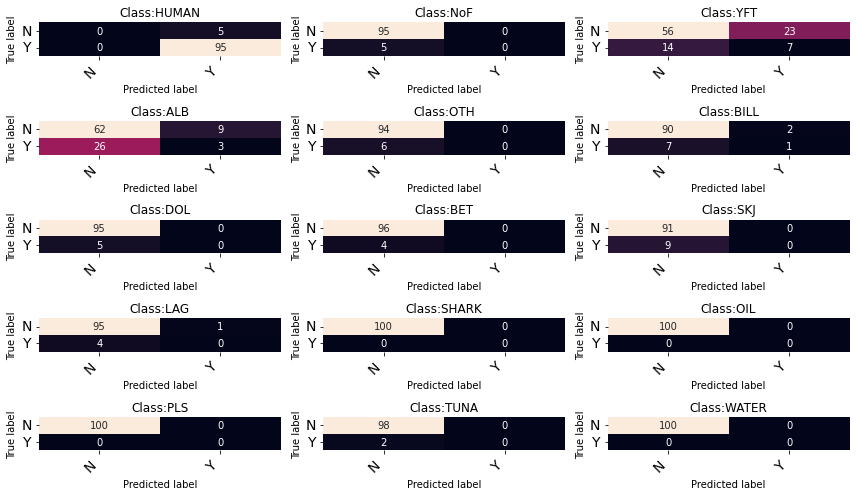

In [41]:
vis_arr = np.asarray(multilabel_confusion_matrix(y_test, y_pred))
labels = ['HUMAN', 'NoF', 'YFT', 'ALB', 'OTH', 'BILL', 'DOL', 'BET', 'SKJ', 'LAG', 'SHARK', 'OIL', 'PLS', 'TUNA', 'WATER']
fig, ax = plt.subplots(5, 3, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
fig.tight_layout()
plt.show()

#['HUMAN', 'NoF', 'YFT', 'ALB', 'OTH', 'BILL', 'DOL', 'BET', 'SKJ', 'LAG', 'SHARK', 'OIL', 'PLS', 'TUNA', 'WATER']
import numpy as np
from sklearn.metrics import confusion_matrix

preds = model2.predict(X_test)
y_pred = np.round(preds) #<TODO: convert the probabilities to classes with numpy>

conf_human=confusion_matrix(y_test[:,0], y_pred[:,0])
conf_nof=confusion_matrix(y_test[:,1], y_pred[:,1])
conf_yft=confusion_matrix(y_test[:,2], y_pred[:,2])
#'ALB', 'OTH', 'BILL',
conf_alb=confusion_matrix(y_test[:,3], y_pred[:,3])
conf_oth=confusion_matrix(y_test[:,4], y_pred[:,4])
conf_bill=confusion_matrix(y_test[:,5], y_pred[:,5])
#'DOL', 'BET', 'SKJ'
conf_dol=confusion_matrix(y_test[:,6], y_pred[:,6])
conf_bet=confusion_matrix(y_test[:,7], y_pred[:,7])
conf_sky=confusion_matrix(y_test[:,8], y_pred[:,8])
#'LAG', 'SHARK', 'OIL'
conf_lag=confusion_matrix(y_test[:,9], y_pred[:,9])
conf_shark=confusion_matrix(y_test[:,10], y_pred[:,10])
conf_oil=confusion_matrix(y_test[:,11], y_pred[:,11])
#'PLS', 'TUNA', 'WATER'
conf_pls=confusion_matrix(y_test[:,12], y_pred[:,12])
conf_tuna=confusion_matrix(y_test[:,13], y_pred[:,13])
conf_water=confusion_matrix(y_test[:,14], y_pred[:,14])


print(conf_human)

conf_human
conf_nof
conf_yft

conf_alb
conf_oth
conf_bill

conf_dol
conf_bet
conf_sky

conf_lag
conf_shark
conf_oil

conf_pls
conf_tuna
conf_water

import seaborn as sns
ax_human = sns.heatmap(conf_human, annot=True, fmt='d', cmap='Blues') 
ax_human.set(xlabel='Predicted Label',
       ylabel='True label', title= 'Human');


ax_nof = sns.heatmap(conf_nof, annot=True, fmt='d', cmap='Blues') 
ax_nof.set(xlabel='Predicted Label',
       ylabel='True label', title= 'NoF');

ax_yft = sns.heatmap(conf_yft, annot=True, fmt='d', cmap='Blues') 
ax_yft.set(xlabel='Predicted Label',
       ylabel='True label', title= 'YFT');

ax_alb = sns.heatmap(conf_alb, annot=True, fmt='d', cmap='Blues') 
ax_alb.set(xlabel='Predicted Label',
       ylabel='True label', title= 'ALB');

ax_oth = sns.heatmap(conf_oth, annot=True, fmt='d', cmap='Blues') 
ax_oth.set(xlabel='Predicted Label',
       ylabel='True label', title= 'OTH');

ax_bill = sns.heatmap(conf_bill, annot=True, fmt='d', cmap='Blues') 
ax_bill.set(xlabel='Predicted Label',
       ylabel='True label', title= 'BILL');

ax_dol = sns.heatmap(conf_dol, annot=True, fmt='d', cmap='Blues') 
ax_dol.set(xlabel='Predicted Label',
       ylabel='True label', title= 'DOL');

ax_bet = sns.heatmap(conf_bet, annot=True, fmt='d', cmap='Blues') 
ax_bet.set(xlabel='Predicted Label',
       ylabel='True label', title= 'BET');

ax_sky = sns.heatmap(conf_sky, annot=True, fmt='d', cmap='Blues') 
ax_sky.set(xlabel='Predicted Label',
       ylabel='True label', title= 'SKY');

ax_lag = sns.heatmap(conf_lag, annot=True, fmt='d', cmap='Blues') 
ax_lag.set(xlabel='Predicted Label',
       ylabel='True label', title= 'LAG');

ax_shark = sns.heatmap(conf_shark, annot=True, fmt='d', cmap='Blues') 
ax_shark.set(xlabel='Predicted Label',
       ylabel='True label', title= 'SHARK');

ax_oil = sns.heatmap(conf_oil, annot=True, fmt='d', cmap='Blues') 
ax_oil.set(xlabel='Predicted Label',
       ylabel='True label', title= 'OIL');

ax_pls = sns.heatmap(conf_pls, annot=True, fmt='d', cmap='Blues') 
ax_pls.set(xlabel='Predicted Label',
       ylabel='True label', title= 'PLS');

ax_tuna = sns.heatmap(conf_tuna, annot=True, fmt='d', cmap='Blues') 
ax_tuna.set(xlabel='Predicted Label',
       ylabel='True label', title= 'TUNA');

ax_water = sns.heatmap(conf_water, annot=True, fmt='d', cmap='Blues') 
ax_water.set(xlabel='Predicted Label',
       ylabel='True label', title= 'WATER');

In [42]:
Y_train= pd.DataFrame(y_train)
Y_test= pd.DataFrame(y_test)
preds2 = np.round(model2.predict(X_test))
Y_preds= pd.DataFrame(preds2)
Y_train.columns
(Y_train.groupby(0).size())



0
0.0     34
1.0    866
dtype: int64

In [43]:
y_labels = ['HUMAN', 'NoF', 'YFT', 'ALB', 'OTH', 'BILL', 'DOL', 'BET', 'SKJ', 'LAG', 'SHARK', 'OIL', 'PLS', 'TUNA', 'WATER']
print(len(y_labels))
counts = []
for i in range(0,15):
    x = list(Y_train.groupby(i).size())
    counts.append(x[0]/1000)
print(counts)
print(len(counts))
frequency= [round(1-i, 3) for i in counts]
print(frequency)
print(len(frequency))

15
[0.034, 0.882, 0.689, 0.614, 0.839, 0.866, 0.863, 0.837, 0.832, 0.884, 0.891, 0.9, 0.899, 0.898, 0.897]
15
[0.966, 0.118, 0.311, 0.386, 0.161, 0.134, 0.137, 0.163, 0.168, 0.116, 0.109, 0.1, 0.101, 0.102, 0.103]
15


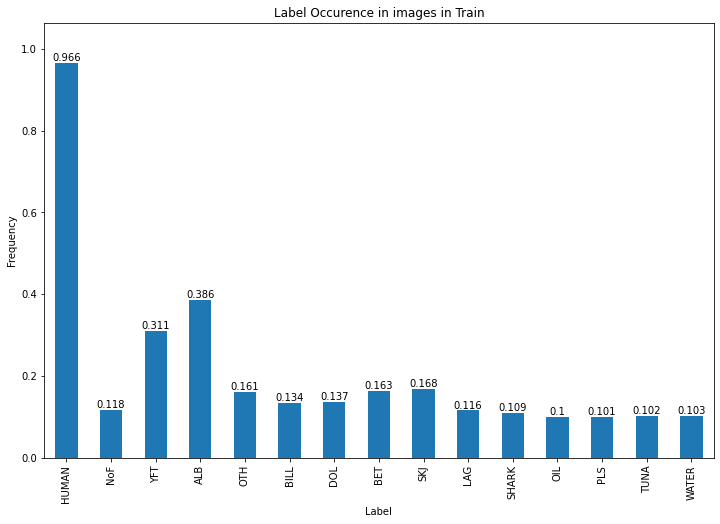

In [44]:
df_counts = pd.DataFrame({'Frequency': frequency}, index=y_labels)
ax = df_counts.plot(kind='bar', figsize=(12, 8), title='Label Occurence in images in Train',
             xlabel='Label', ylabel='Frequency', legend=False)

# annotate
ax.bar_label(ax.containers[0], label_type='edge')

# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)

In [45]:
Y_test.groupby(3).size()

3
0.0    71
1.0    29
dtype: int64

In [46]:
print(len(y_labels))
counts = []
for i in range(0,15):
    x = list(Y_test.groupby(i).size())
    counts.append(x[0]/100)
print(counts)
print(len(counts))
frequency= [round(1-i, 3) for i in counts]
print(frequency)
print(len(frequency))

15
[0.05, 0.95, 0.79, 0.71, 0.94, 0.92, 0.95, 0.96, 0.91, 0.96, 1.0, 1.0, 1.0, 0.98, 1.0]
15
[0.95, 0.05, 0.21, 0.29, 0.06, 0.08, 0.05, 0.04, 0.09, 0.04, 0.0, 0.0, 0.0, 0.02, 0.0]
15


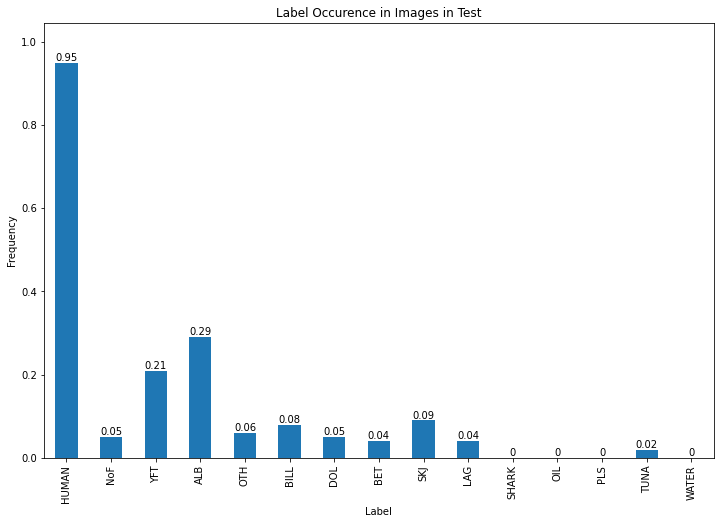

In [47]:
df_counts = pd.DataFrame({'Frequency': frequency}, index=y_labels)
ax = df_counts.plot(kind='bar', figsize=(12, 8), title='Label Occurence in Images in Test',
             xlabel='Label', ylabel='Frequency', legend=False)

# annotate
ax.bar_label(ax.containers[0], label_type='edge')

# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)

In [48]:
Y_preds.groupby(0).size()[1]==100
#list(Y_preds.groupby(0).size())

True

In [49]:
print(len(y_labels))
counts = []
for i in range(0,15):
    x = list(Y_preds.groupby(i).size())
    if i == 0:
        counts.append(0)
    else:
        counts.append(x[0]/100)
print(counts)
print(len(counts))
frequency= [round(1-i, 3) for i in counts]
print(frequency)
print(len(frequency))

15
[0, 1.0, 0.7, 0.88, 1.0, 0.97, 1.0, 1.0, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0]
15
[1, 0.0, 0.3, 0.12, 0.0, 0.03, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]
15


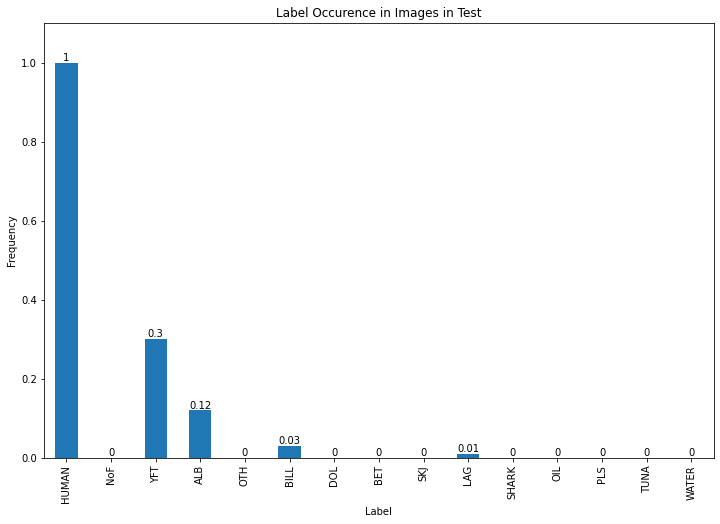

In [50]:
df_counts = pd.DataFrame({'Frequency': frequency}, index=y_labels)
ax = df_counts.plot(kind='bar', figsize=(12, 8), title='Label Occurence in Images in Test',
             xlabel='Label', ylabel='Frequency', legend=False)

# annotate
ax.bar_label(ax.containers[0], label_type='edge')

# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)